### plotting tanh activation toy 1D example

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


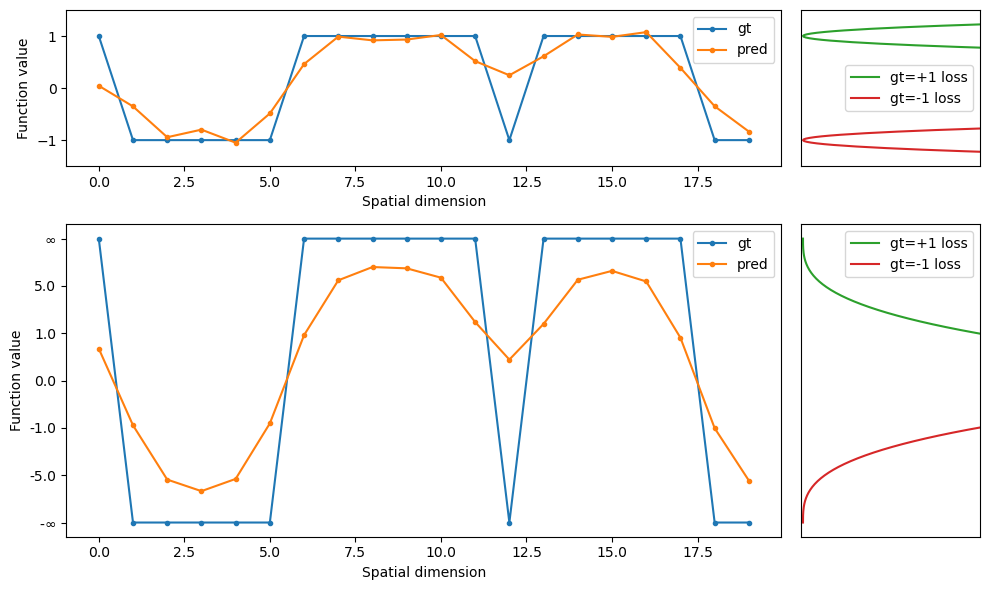

In [105]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd


gt = np.random.rand(20)
gt = nd.gaussian_filter1d(gt,1)
gt = ((gt>0.5)*2-1).astype(float)
pred = nd.gaussian_filter(gt,1)+np.random.randn(20)*0.1
gt2 = gt*10
pred2 = nd.gaussian_filter(gt2,1)*0.8+np.random.randn(20)*0.1
fig, ax = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 2]})

t = np.linspace(-1.5,1.5,200)
t2 = np.linspace(-10,10,200)

gt_p1 = (t-1)**2*20
gt_m1 = (t+1)**2*20
gt2_p1 = np.abs(t2-10)**3/300
gt2_m1 = np.abs(t2+10)**3/300

for i in range(2):
    ax[i,0].plot([gt,gt2][i],".-",label="gt")
    ax[i,0].plot([pred,pred2][i],".-",label="pred")
    ax[i,0].set_xlabel("Spatial dimension")
    ax[i,0].set_ylabel("Function value")

    ax[i,0].legend()
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])    


    ax[i,1].plot([gt_p1,gt2_p1][i],[t,t2][i],"-",color=f"C{2}",label="gt=+1 loss")
    ax[i,1].plot([gt_m1,gt2_m1][i],[t,t2][i],"-",color=f"C{3}",label="gt=-1 loss")
    ax[i,1].legend()
    ax[i,1].set_xlim(-0.01,1)
    yy = [1.5,11][i]
    ax[i,0].set_ylim(-yy,yy)
    ax[i,1].set_ylim(-yy,yy)
y_tick_pos = np.linspace(-10,10,7)
y_tick_labels =["-$\infty$"]+ [-5.0,-1.0,0.0,1.0,5.0]+["$\infty$"]
plt.sca(ax[1,0])
_=plt.yticks(y_tick_pos,y_tick_labels)
plt.tight_layout()

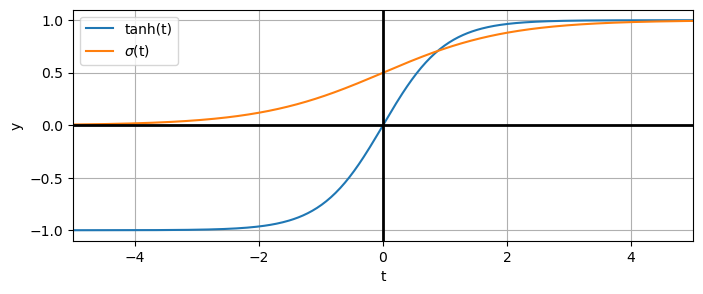

In [115]:
#plot tanh(t) and sigmoid(t) from -5 to 5
plt.figure(figsize=(8, 3))
t = np.linspace(-5,5,400)
y = np.tanh(t)
y2 = 1/(1+np.exp(-t))
plt.plot(t,y,"-",label="tanh(t)")
plt.plot(t,y2,"-",label="$\sigma$(t)")
plt.grid()
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(-5,5)
plt.axhline(linewidth=2, color='k')
plt.axvline(linewidth=2, color='k')
plt.legend()

In [ ]:
def always_return_1():
    return 1
def always_return_0():
    return 0
    

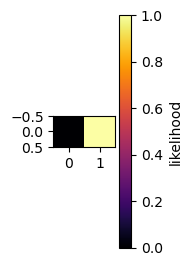

In [112]:
#make inferno colorbar
plt.figure(figsize=(1,4))
plt.imshow([[0,1]],cmap="inferno")
plt.colorbar(label="likelihood")

### Cleanup functions

In [8]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./source/')
from utils import nuke_saves_folder
from argparse_utils import kill_missing_ids

#help(kill_missing_ids)
#help(nuke_saves_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
dry = False
kill_missing_ids(name_key="sample_opts",dry=dry)
kill_missing_ids(name_key="args",dry=dry)

Removing id=vali-ts10_3 from sample_opts.
Removing id=train-ts10_3 from sample_opts.
Removing id=self_cond_gw2_ema_3 from sample_opts.
Removing id=vali-ts10_4 from sample_opts.
Removing id=train-ts10_4 from sample_opts.
Removing id=self_cond_gw2_ema_4 from sample_opts.
Removing id=vali-ts10_10 from sample_opts.
Removing id=train-ts10_10 from sample_opts.
Removing id=self_cond_gw2_ema_10 from sample_opts.
Removing id=vali-ts10_12 from sample_opts.
Removing id=train-ts10_12 from sample_opts.
Removing id=vali-ts10_5 from sample_opts.
Removing id=train-ts10_5 from sample_opts.
Removing id=self_cond_gw2_ema_5 from sample_opts.
Keeping 82 ids out of 96 in sample_opts.
Removing id=sam[64_nc]_1 from args.
Removing id=sam[128_nc]_1 from args.
Removing id=sam[64_nc_slow]_0 from args.
Removing id=sam[64_nc_slow]_1 from args.
Removing id=sam[64_nc_slow]_2 from args.
Removing id=sam[64_nc_slow]_3 from args.
Removing id=sam[64_nc_slow]_4 from args.
Removing id=sam[64_nc_slow]_5 from args.
Removing i

In [11]:
nuke_saves_folder(dry_run=True)

No folders to remove.


### collect gen_table data

In [33]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from argparse_utils import TieredParser, get_ckpt_name,load_existing_args
from source.plot_utils import collect_gen_table
from utils import save_dict_list_to_json,wildcard_match
from pathlib import Path
import re



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:


def collect_gen_table(gen_id_patterns="gw_sweep_*",
                   model_id_patterns="*",
                   save=False,
                   return_table=True,
                   save_name="",
                   verbose=True,
                   sort_by_save_path=True,
                   make_pretty_table=True,
                   pretty_digit_limit=5,
                   search_gen_setups_instead=False,
                   include_mode="last"):
    assert include_mode in ["last","last_per_gen_id","all"], f"expected include_mode to be one of ['last','last_per_gen_id','all'], found {include_mode}"
    if isinstance(gen_id_patterns,str):
        gen_id_patterns = [gen_id_patterns]
    if isinstance(model_id_patterns,str):
        model_id_patterns = [model_id_patterns]
    model_id_dict = TieredParser().load_and_format_id_dict()
    
    save_paths = []
    table = pd.DataFrame()
    for model_id,v in model_id_dict.items():
        matched = False
        for model_id_pattern in model_id_patterns:
            if wildcard_match(model_id_pattern,model_id):
                matched = True
                break
        if matched:
            fn = Path(v["save_path"])/"logging_gen.csv"
            if fn.exists():
                with open(str(fn),"r") as f:
                    column_names = f.readline()[:-1].split(",")
                data = np.genfromtxt(str(fn), dtype=str, delimiter=",")[1:]
                if data.size==0:
                    continue
                if "gen_id" not in column_names:
                    continue
                if search_gen_setups_instead:
                    file_gen_ids = data[:,column_names.index("setup_name")].astype(str)
                else:
                    file_gen_ids = data[:,column_names.index("gen_id")].astype(str)
                match_idx = set()

                for idx,fgi in enumerate(file_gen_ids):
                    for gen_id_pattern in gen_id_patterns:
                        if wildcard_match(gen_id_pattern,fgi):
                            match_idx.add(idx)
                            break
                if len(match_idx)==0:
                    continue
                if include_mode=="last":
                    match_idx = [max(match_idx)]
                    if verbose and len(match_idx)>1:
                        print(f"Warning: multiple matches found for model_id {model_id} and gen_ids {data[match_idx,column_names.index('gen_id')]}")
                elif include_mode=="last_per_gen_id":
                    len_before = len(match_idx)
                    match_idx = list(match_idx)
                    match_idx = [max([i for i in match_idx if file_gen_ids[i]==file_gen_ids[j]]) for j in match_idx]
                    if verbose and len(match_idx)<len_before:
                        print(f"Warning: multiple matches found for model_id {model_id} and gen_ids {data[match_idx,column_names.index('gen_id')]}")
                else:
                    match_idx = list(match_idx)
                match_data_s = data[match_idx]
                table = pd.concat([table,pd.DataFrame(match_data_s,columns=column_names)],axis=0)
                save_paths.extend([v["save_path"] for _ in range(len(match_idx))])
    if table.shape[0]==0:
        if return_table:
            return table
        else:
            return
    table["save_path"] = save_paths
    if sort_by_save_path:
        table = table.sort_values(by=["save_path"])
    table = table.loc[:, (table != "").any(axis=0)]
    table_pd = table.copy()
    table = {k: table[k].tolist() for k in table.keys()}
    if make_pretty_table:
        buffer = 2
        pretty_table = ["" for _ in range(len(table["save_path"])+2)] 
        for k in table.keys():
            pretty_col = ["" for _ in range(len(table["save_path"])+2)]
            
            if table[k][0].replace(".","").isdigit() and table[k][0].find(".")>=0:
                idx = slice(pretty_digit_limit+2)
            else:
                idx = slice(None)
            max_length = max(max([len(str(x)[idx]) for x in table[k]]),len(k))+buffer
            pretty_col[0] = k+" "*(max_length-len(k))
            pretty_col[1] = "#"*max_length
            pretty_col[2:] = [str(x)[idx]+" "*(max_length-len(str(x)[idx])-2)+", " for x in table[k]]
            if k=="model_name":
                pretty_col[0] = "model_name"+" "*(max_length-len("model_name")-1)+"# "
                pretty_col[1] = "#"*(max_length+1)
                pretty_col[2:] = [s.replace(","," #") for s in pretty_col[2:]]
                pretty_table = [pretty_col[i]+pretty_table[i] for i in range(len(pretty_table))]
            else:
                pretty_table = [pretty_table[i]+pretty_col[i] for i in range(len(pretty_table))]
        table["pretty_table"] = pretty_table
    if save:
        save_dict_list_to_json(table,save_name,append=True)
    if return_table:
        return table_pd

table = collect_gen_table(model_id_patterns="sam[64",include_mode="all")
table

ari      gen_id gen_setup                 hiou  \
0  0.08546995807881244  gw_sweep_0  gw_sweep  0.04201299429793007   
1   0.6393827562938397  gw_sweep_1  gw_sweep  0.15654332347969174   
2   0.6668579952888827  gw_sweep_2  gw_sweep  0.15466394625343807   
3   0.6969186681615543  gw_sweep_3  gw_sweep  0.13923884072413917   
4    0.735149173928091  gw_sweep_4  gw_sweep  0.11396911996331567   
5   0.7396794518906913  gw_sweep_5  gw_sweep  0.09447390005928721   
6   0.7274255438394538  gw_sweep_6  gw_sweep  0.08787571529252704   
7   0.6802219664138779  gw_sweep_7  gw_sweep  0.07122642063342702   

                     iou              max_ari             max_hiou  \
0  0.0007204451638843982  0.08546995807881244  0.04201299429793007   
1   0.001798824499007684   0.6393827562938397  0.15654332347969174   
2  0.0020510991609712257   0.6668579952888827  0.15466394625343807   
3  0.0019387904217324514   0.6969186681615543  0.13923884072413917   
4  0.0024757513583639162    0.735149173928091  0.11396911996331567   
5  0.0019411756056701868   0.7396794518906913  0.09447390005928721   
6  0.0017463082054561107   0.7274255438394538  0.08787571529252704   
7  0.0017928640351255317   0.6802219664138779  0.07122642063342702   

                    mi    step  \
0  0.18687843408461405  100000   
1   0.6498147561861398  100000   
2   0.6667084704597167  100000   
3   0.6796675034870705  100000   
4   0.6951301673215654  100000   
5   0.6793390057029413  100000   
6   0.6614292696297609  100000   
7    0.590612662974588  100000   

                                           save_path  
0  saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...  
1  saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...  
2  saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...  
3  saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...  
4  saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...  
5  saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...  
6  saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...  
7  saves/ver-1.0.0/2024-02-22-17-44_sam[64_native...

In [45]:
import numpy as np
ari_array = table["ari"].astype(float).to_numpy()
table["ari"].astype(float)

0    0.085470
1    0.639383
2    0.666858
3    0.696919
4    0.735149
5    0.739679
6    0.727426
7    0.680222
Name: ari, dtype: float64

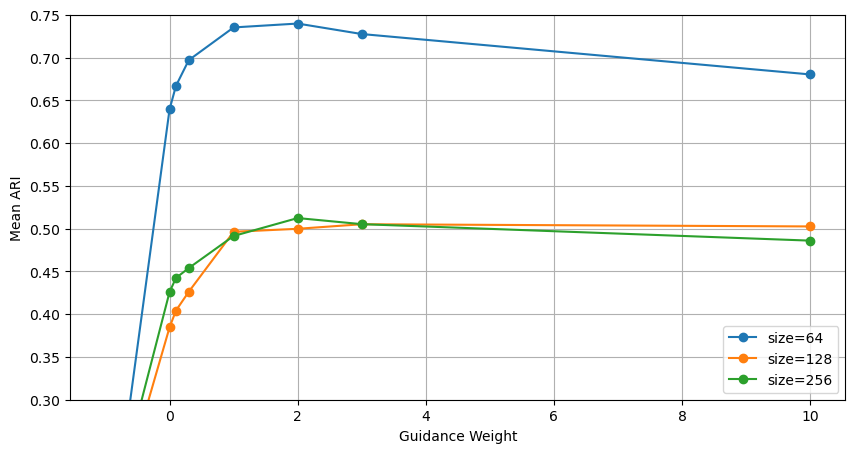

In [51]:
plt.figure(figsize=(10, 5))
gw = "-1.0;0.0;0.1;0.3;1.0;2.0;3.0;10.0".split(";")
gw  = [float(x) for x in gw]
for size in ["64","128","256"]:
    table = collect_gen_table(model_id_patterns="sam["+size,include_mode="all")
    plt.plot(gw,table["ari"].astype(float).to_numpy(),"o-",label=f"size={size}")
plt.xlabel("Guidance Weight")
plt.ylabel("Mean ARI")
plt.ylim(0.3,0.75)
plt.grid()
plt.legend()

### dataset testing

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os,sys
sys.path.append('./source/')
sys.path.append('./data/')
import numpy as np
from PIL import Image
from pathlib import Path
from training import DiffusionModelTrainer
from argparse_utils import TieredParser
from source.datasets import SegmentationDataset, custom_collate_with_info
import jlc
import torch

In [17]:
args = TieredParser().get_args(alt_parse_args=["--model_name","sam[64_native_tanh]", "--model_version","1.0.0"])
args.ckpt_name = "saves/ver-1.0.0/2024-02-22-17-44_sam[64_native_tanh]_2/ckpt_*.pt"
args.save_path = "saves/2024-02-22-17-44_sam[64_native_tanh]_2"
args.mode = "gen"
trainer = DiffusionModelTrainer(args)


Setting up generation.
CUDA available. Using GPU.
Number of trainable parameters: 27797382
Saving to: saves/2024-02-22-17-44_sam[64_native_tanh]_2
Init complete.


In [24]:
splits = ["train","vali","test"]
trainer.create_datasets(splits)
samples = {s: [] for s in splits}
for s in splits:
    #print(len(getattr(trainer,s+"_dl")))
    for i in range(len(getattr(trainer,s+"_dl"))):
        item_i = getattr(trainer,s+"_dl").dataloader.dataset.items[i]
        samples[s].append(item_i["dataset_name"]+"/"+str(+item_i["i"]))

In [36]:
for s in splits:
    print(f"#samples in        {s}: {len(samples[s])}")
    print(f"#unique samples in {s}: {len(set(samples[s]))}")
print(f"#samples in        all splits: {len(samples['train']+samples['vali']+samples['test'])}")
print(f"#unique samples in all splits: {len(set(samples['train']+samples['vali']+samples['test']))}")


#samples in        train: 36396
#unique samples in train: 36396
#samples in        vali: 4592
#unique samples in vali: 4592
#samples in        test: 4555
#unique samples in test: 4555
#samples in        all splits: 45543
#unique samples in all splits: 45543


In [30]:

split = "vali"
samples = []
n_total = []
n_datatest = []
for d in datasets:
    trainer.args.datasets = d
    trainer.create_datasets(split)
    s = []
    n = len(getattr(trainer,split+"_dl").dataloader.dataset)
    for i in range(n):
        item_i = getattr(trainer,split+"_dl").dataloader.dataset.items[i]
        if item_i["dataset_name"]==dataset_test:
            s.append(item_i["dataset_name"]+"/"+str(+item_i["i"]))
    n_total.append(n)
    n_datatest.append(len(s))
    samples.extend(s)

processing dataset:  cityscapes
processing dataset:  cityscapes
processing dataset:  coift
processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  monu
processing dataset:  monu4
processing dataset:  ade20k
processing dataset:  dram
processing dataset:  cityscapes
processing dataset:  coco
processing dataset:  pascal
processing dataset:  sa1b
processing dataset:  coift
processing dataset:  hrsod
processing dataset:  to5k
processing dataset:  ade20k
processing dataset:  dram
processing dataset:  cityscapes
processing dataset:  cityscapes
processing dataset:  ade20k
processing dataset:  dram


In [32]:
trainer.split_method = "native"
trainer.args.datasets = dataset_test
trainer.create_datasets(split)
s = []
n = len(getattr(trainer,split+"_dl").dataloader.dataset)
for i in range(n):
    item_i = getattr(trainer,split+"_dl").dataloader.dataset.items[i]
    if item_i["dataset_name"]==dataset_test:
        s.append(item_i["dataset_name"]+"/"+str(+item_i["i"]))
n_total.append(n)
n_datatest.append(len(s))
samples.extend(s)

processing dataset:  cityscapes


In [33]:
uq, counts = np.unique(samples,return_counts=True)
print(f"#samples in        {dataset_test} {split}: {len(samples)}")
print(f"#unique samples in {dataset_test} {split}: {len(uq)}")
print(f"min count: {min(counts)}")
print(f"max count: {max(counts)}")

#samples in        cityscapes vali: 3000
#unique samples in cityscapes vali: 500
min count: 6
max count: 6


# SAM evaluation

In [9]:
"""

args = TieredParser().get_args(alt_parse_args=["--model_name","sam[64_native_tanh]", 
                                               "--model_version","1.0.0",
                                               "--ckpt_name", "*sam[64_native_tanh]*"])
args.save_path = "saves/2024-02-22-17-44_sam[64_native_tanh]_2"
args.mode = "gen"
trainer = DiffusionModelTrainer(args)
trainer.create_datasets("vali",args={"datasets": "ade20k"})
dataloader = DiffusionModelTrainer.create_datasets(None,"vali")
ckpt_type_dict = {"vit_b": "sam_vit_b_01ec64.pth",#89 670 912 #params
                  "vit_l": "sam_vit_l_0b3195.pth",#308 278 272 #params
                  "vit_h": "sam_vit_h_4b8939.pth"}#637 026 048 #params
model_type = "vit_b"
sam_checkpoint = "../segment-anything/segment_anything/checkpoint/"+ckpt_type_dict[model_type]

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

generator_kwargs = {"points_per_side": 32,
                    "pred_iou_thresh": 0.86,
                    "stability_score_thresh": 0.92,
                    "crop_n_layers": 1,
                    "crop_n_points_downscale_factor": 2,
                    "min_mask_region_area": 100}"""

'\n\nargs = TieredParser().get_args(alt_parse_args=["--model_name","sam[64_native_tanh]", \n                                               "--model_version","1.0.0",\n                                               "--ckpt_name", "*sam[64_native_tanh]*"])\nargs.save_path = "saves/2024-02-22-17-44_sam[64_native_tanh]_2"\nargs.mode = "gen"\ntrainer = DiffusionModelTrainer(args)\ntrainer.create_datasets("vali",args={"datasets": "ade20k"})\ndataloader = DiffusionModelTrainer.create_datasets(None,"vali")\nckpt_type_dict = {"vit_b": "sam_vit_b_01ec64.pth",#89 670 912 #params\n                  "vit_l": "sam_vit_l_0b3195.pth",#308 278 272 #params\n                  "vit_h": "sam_vit_h_4b8939.pth"}#637 026 048 #params\nmodel_type = "vit_b"\nsam_checkpoint = "../segment-anything/segment_anything/checkpoint/"+ckpt_type_dict[model_type]\n\ndevice = "cuda"\n\nsam = sam_model_registry[model_type](checkpoint=sam_checkpoint)\nsam.to(device=device)\n\ngenerator_kwargs = {"points_per_side": 32,\n       

In [2]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os,sys
import argparse
sys.path.append('./source/')
sys.path.append("..")
from utils import imagenet_preprocess
from training import DiffusionModelTrainer
from argparse_utils import TieredParser
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from plot_utils import mask_overlay_smooth
from collections import defaultdict
from utils import get_segment_metrics_np
import tqdm

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def get_segmentation(anns):
    h, w = anns[0]['segmentation'].shape
    segment = np.zeros((h,w), dtype=np.uint8)
    for k, ann in enumerate(anns):
        segment[ann['segmentation']] = min(255, k+1)
    return segment

class SamAgnosticPredictor(SamPredictor):
    def __init__(self, sam, generator_kwargs={}):
        super().__init__(sam)
        self.mask_generator = SamAutomaticMaskGenerator(sam,**generator_kwargs)
        self.has_stored_features = False
        self.data_root = os.path.abspath("./data")
        
    def store_image_batch(self, features):
        self.stored_features = features
        self.has_stored_features = True
        self.stored_idx = 0

    def restore_next(self):
        self.features = self.stored_features[self.stored_idx]
        self.stored_idx += 1
        if self.stored_idx == len(self.stored_features):
            self.has_stored_features = False

    def batched_generate(self, images, gts, image_features=None):
        if image_features is not None:
            self.store_image_batch(image_features)
        masks = []
        for i in range(len(images)):
            image = images[i]
            mask = self.mask_generator.generate(image)
            masks.append(mask)
        segmentations = [get_segmentation(mask) for mask in masks]
        return segmentations

    def batched_generate_raw(self, model_kwargs,info):
        if "image_features" in model_kwargs.keys():
            self.store_image_batch(model_kwargs["image_features"])
        images = []
        gts = []
        for i in range(len(info)):
            image_path = os.path.join(self.data_root,info[i]["dataset_name"],info[i]["image_path"])
            label_path = os.path.join(self.data_root,info[i]["dataset_name"],info[i]["label_path"])
            images.append(np.array(Image.open(image_path)))
            gts.append(np.array(Image.open(label_path)))
        bs = len(info)
        masks = []
        for i in range(bs):
            image = images[i]
            mask = self.mask_generator.generate(image)
            masks.append(mask)
        return masks, images, gts
    
    @torch.no_grad()
    def set_torch_image(self,transformed_image,original_image_size):
        assert (
            len(transformed_image.shape) == 4
            and transformed_image.shape[1] == 3
            and max(*transformed_image.shape[2:]) == self.model.image_encoder.img_size
        ), f"set_torch_image input must be BCHW with long side {self.model.image_encoder.img_size}."
        self.reset_image()

        self.original_size = original_image_size
        self.input_size = tuple(transformed_image.shape[-2:])
        if self.has_stored_features:
            self.features = self.restore_next()
        else:
            input_image = self.model.preprocess(transformed_image)
            self.features = self.model.image_encoder(input_image)
        self.is_image_set = True

In [14]:
def evaluate_sam(datasets="ade20k",
                 model_type=0,
                 model_name_for_dataloader="sam[64_native_tanh]",
                 num_return_segments=0,
                 split="vali",
                 ratio_of_dataset=1.0,
                 generator_kwargs={},
                 longest_side_resize=0,
                 progress_bar=True,
                 device="cuda",
                 batch_size=4,
                 full_resolution_decoder=False):
    if not isinstance(datasets,list):
        assert isinstance(datasets,str), "datasets must be a string or a list of strings"
        datasets = datasets.split(",")
    if isinstance(model_type,int):
        assert model_type in [0,1,2], "model_type must be one of [0,1,2] or one of [vit_b, vit_l, vit_h]"
        model_type = ["vit_b","vit_l","vit_h"][model_type]
    if isinstance(split,int):
        assert split in [0,1,2,3], "split must be one of [0,1,2,3] or one of [train,vali,test,all]"
        split = ["train","vali","test","all"][split]
    assert num_return_segments<=64
    
    assert isinstance(longest_side_resize,int), "longest_side_resize must be an integer"

    args = TieredParser().get_args(alt_parse_args=["--model_name", model_name_for_dataloader,
                                                    "--model_version","1.0.0",
                                                    "--ckpt_name", "*"+model_name_for_dataloader+"*",
                                                    "--mode","data",
                                                    "--train_batch_size",str(batch_size)])
    if longest_side_resize>0 and not longest_side_resize==1024:
        args.image_size = longest_side_resize
        args.crop_method = "sam_small"
    trainer = DiffusionModelTrainer(args)
    trainer.create_datasets("vali",args={"datasets": "ade20k"})
    load_raw_image_label = getattr(trainer,split+"_dl").dataloader.dataset.load_raw_image_label
    ckpt_type_dict = {"vit_b": "sam_vit_b_01ec64.pth",#89 670 912 #params
                  "vit_l": "sam_vit_l_0b3195.pth",#308 278 272 #params
                  "vit_h": "sam_vit_h_4b8939.pth"}#637 026 048 #params
    sam_checkpoint = "../segment-anything/segment_anything/checkpoint/"+ckpt_type_dict[model_type]
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    sam_agnostic = SamAgnosticPredictor(sam,generator_kwargs=generator_kwargs)
    n = len(getattr(trainer,split+"_dl"))
    n_batches = np.ceil(n*ratio_of_dataset).astype(int)
    n_batches = min(n_batches,n)
    assert n_batches>0, "no data found"
    seg_return = []
    metrics_all = defaultdict(list)
    print(f"evaluating {n_batches} batches")
    for i in tqdm.tqdm(range(n_batches),disable=not progress_bar):
        batch = next(getattr(trainer,split+"_dl"))
        x, model_kwargs, info = trainer.get_kwargs(batch,gen=True)
        features = model_kwargs["image_features"]
        bs = len(batch[-1])
        images = []
        gts = []
        for i in range(bs):
            image,gt = load_raw_image_label(info[i],longest_side_resize=0 if full_resolution_decoder else longest_side_resize)
            images.append(image)
            gts.append(gt)
        segmentations = sam_agnostic.batched_generate(images,gts,features)
        seg_return.extend(segmentations[:min(num_return_segments-len(seg_return),bs)])
        metrics = [get_segment_metrics_np(gt,seg) for gt,seg in zip(gts,segmentations)]
        for k,v in metrics[0].items():
            metrics_all[k].extend([m[k] for m in metrics])

    metrics_mean = {k: np.mean(v) for k,v in metrics_all.items()}
    metrics_all = dict(metrics_all)
    return metrics_all, metrics_mean, seg_return

metrics_all, metrics_mean, seg_return = evaluate_sam(datasets="ade20k",
                                                     model_type=0,
                                                     num_return_segments=16,
                                                     split="vali",
                                                     ratio_of_dataset=0.1,
                                                     generator_kwargs={},
                                                     longest_side_resize=64,
                                                     batch_size=4)

CUDA available. Using GPU.
Number of trainable parameters: 0
Saving to: 
Data mode, no training loop.
Init complete.
processing dataset:  ade20k
evaluating 69 batches


100%|██████████| 69/69 [04:21<00:00,  3.79s/it]


In [8]:
python sample.py --gen_setup all_ade20k --name_match_str "*sam[256_native_tanh]*" --num_timesteps 25 --num_samples 2000

(48, 64)

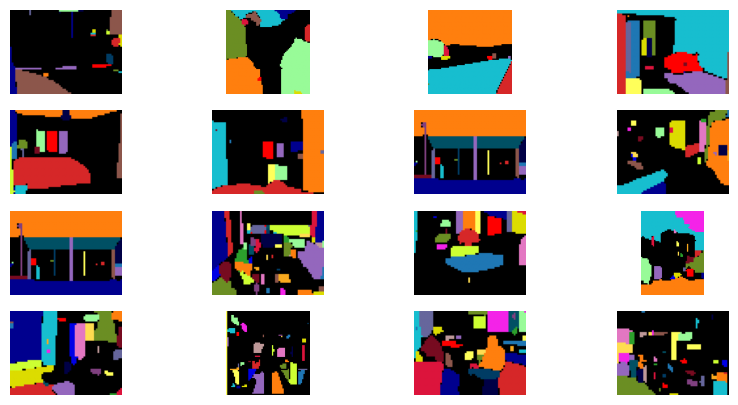

In [13]:
plt.figure(figsize=(10, 5))
n_images = 16
for i in range(n_images):
    plt.subplot(4,4,i+1)
    plt.imshow(mask_overlay_smooth(seg_return[i][:,:,None]*0.5,seg_return[i][:,:,None],alpha_mask=1.0))
    plt.axis("off")

In [8]:
longest_side_resize = 128
datasets = "ade20k"
model_name_for_dataloader = "sam[64_native_tanh]"
split = "vali"
batch_size = 4
args = argparse.Namespace(datasets=datasets)
if longest_side_resize>0 and not longest_side_resize==1024:
    args.image_size = longest_side_resize
    args.crop_method = "sam_small"
args = TieredParser().get_args(alt_parse_args=["--model_name", model_name_for_dataloader,
                                                "--model_version","1.0.0",
                                                "--ckpt_name", "*"+model_name_for_dataloader+"*",
                                                "--mode","data",
                                                "--train_batch_size",str(batch_size)])
trainer = DiffusionModelTrainer(args)
trainer.create_datasets("vali",args={"datasets": "ade20k"})
dr = getattr(trainer,split+"_dl").dataloader.dataset.data_root
load_raw_image_label = getattr(trainer,split+"_dl").dataloader.dataset.load_raw_image_label
batch = next(getattr(trainer,split+"_dl"))
x, model_kwargs, info = trainer.get_kwargs(batch,gen=True)

CUDA available. Using GPU.
Number of trainable parameters: 0
Saving to: 
Data mode, no training loop.
Init complete.
processing dataset:  ade20k


In [ ]:
vali_datasetes = ["ade20k","coco","cityscapes"]

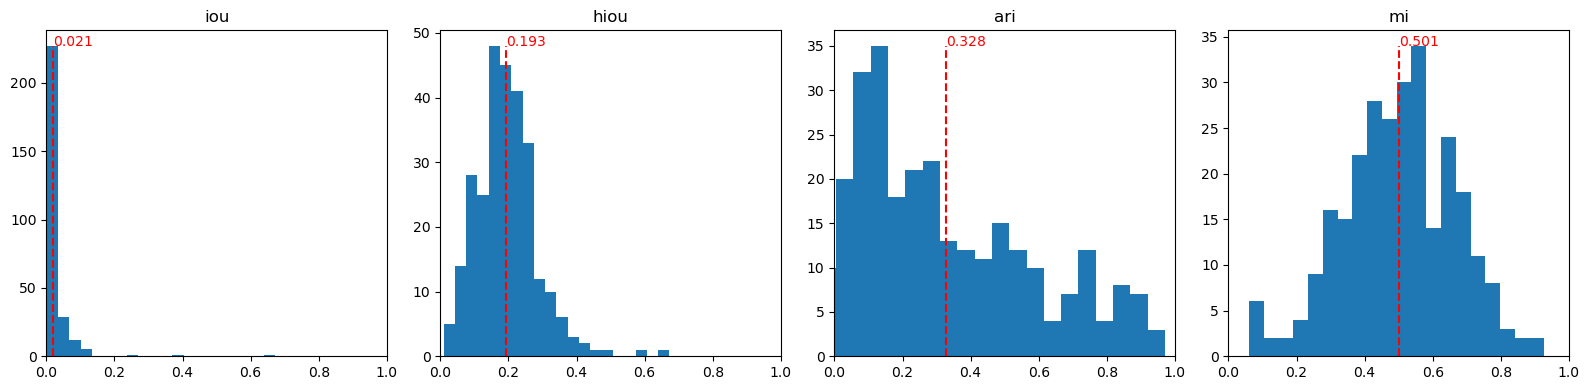

In [15]:
def nice_metric_hist(metrics_all,figsize=(16,4),plot_means=True):
    plt.figure(figsize=figsize)
    for i,k in enumerate(metrics_all.keys()):
        plt.subplot(1,len(metrics_all),i+1)
        h = plt.hist(metrics_all[k],bins=20)
        if plot_means:
            plt.plot([np.mean(metrics_all[k]),np.mean(metrics_all[k])],[0,max(h[0])],"r--",label="mean")
            plt.text(np.mean(metrics_all[k]),max(h[0]),f"{np.mean(metrics_all[k]):.3f}",color="r")
        plt.xlim(0,1)
        plt.title(k)
    plt.tight_layout()
    plt.show()
    
nice_metric_hist(metrics_all)

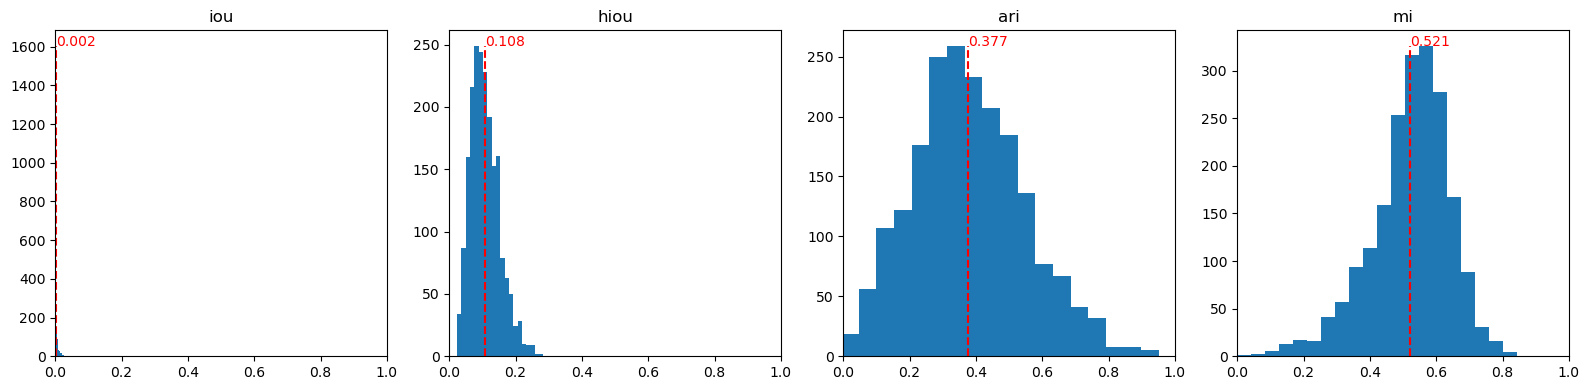

In [3]:


def nice_metric_hist_from_light_stats(filename,figsize=(16,4),plot_means=True):
    plt.figure(figsize=figsize)
    with open(filename,"r") as f:
        light_stats = json.load(f)
    metrics_all = defaultdict(list)
    for i in range(len(light_stats)):
        for k,v in light_stats[i]["metrics"].items():
            metrics_all[k].extend(v)
    for i,k in enumerate(metrics_all.keys()):
        plt.subplot(1,len(metrics_all),i+1)
        h = plt.hist(metrics_all[k],bins=20)
        if plot_means:
            plt.plot([np.mean(metrics_all[k]),np.mean(metrics_all[k])],[0,max(h[0])],"r--",label="mean")
            plt.text(np.mean(metrics_all[k]),max(h[0]),f"{np.mean(metrics_all[k]):.3f}",color="r")
        plt.xlim(0,1)
        plt.title(k)
    plt.tight_layout()

#filename = "./saves/ver-1.0.0/2024-02-22-17-44_sam[64_native_tanh]_2/samples/light_stats_all_ade20k_3_100000.json"
#filename = "./saves/ver-1.0.0/2024-02-23-04-24_sam[128_native_tanh]_0/samples/light_stats_all_ade20k_4_100000.json"
#filename = "./saves/ver-1.0.2/03-01-09-49_weak[128samcrop]_0/samples/light_stats_all_ade20k_6_005000.json"
#filename = "./saves/ver-1.0.2/03-01-09-29_weak[64samcrop]_0/samples/light_stats_all_ade20k_7_010000.json"
filename = "./saves/ver-1.0.0/2024-02-23-23-01_sam[256_native_tanh]_1/samples/light_stats_all_ade20k_8_100000.json"
nice_metric_hist_from_light_stats(filename)

In [7]:
sam_agnostic = SamAgnosticPredictor(sam)
batch = next(trainer.vali_dl)
x_gt,model_kwargs,info = trainer.get_kwargs(batch, gen=True)
masks, images, gts = sam_agnostic.batched_generate(model_kwargs,info)

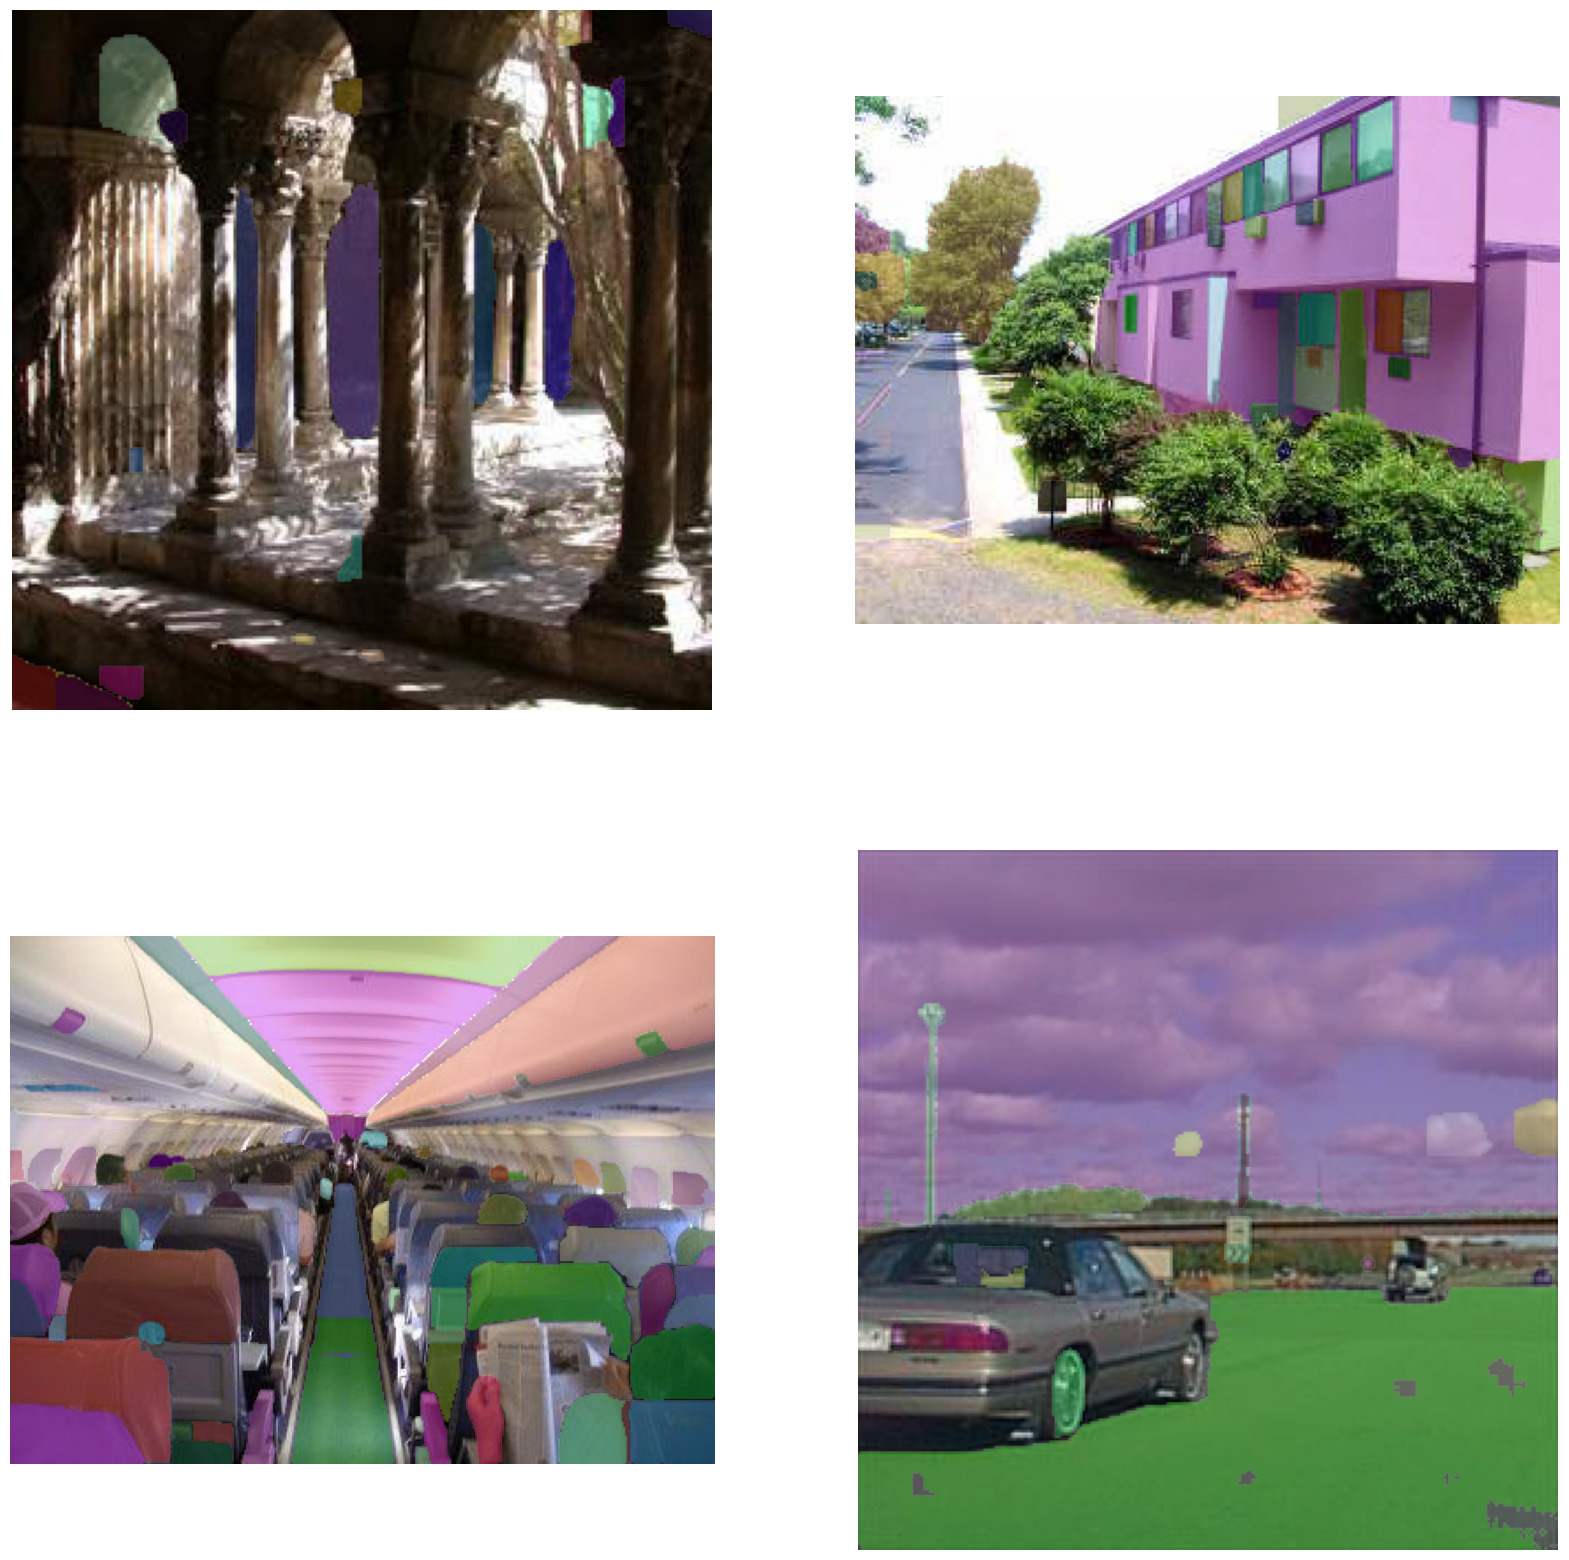

In [8]:
plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    show_anns(masks[i])
    plt.axis('off')


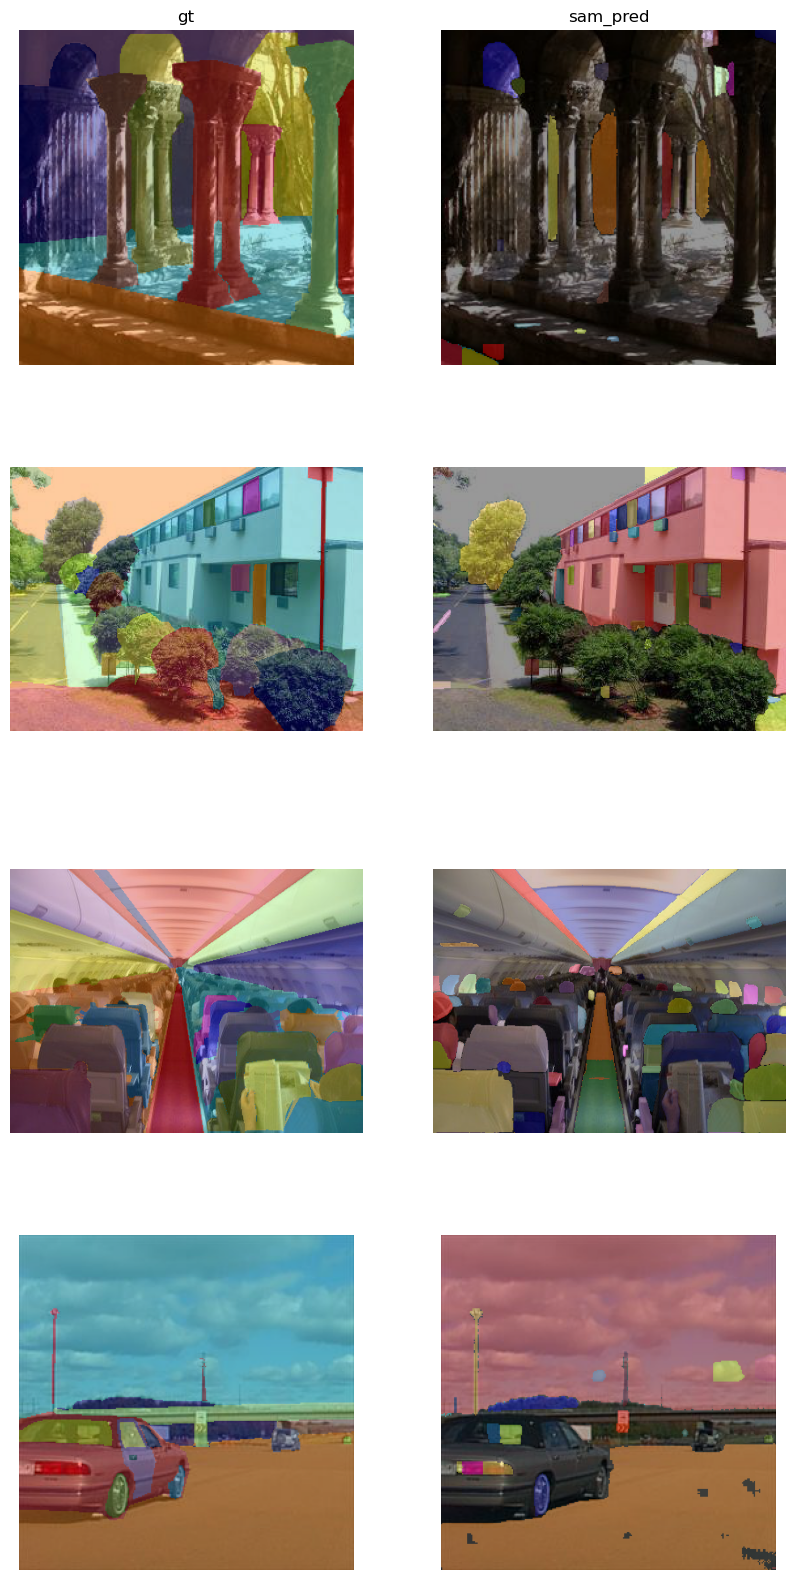

In [10]:

plt.figure(figsize=(10,20))
n_image = len(images)
gts_titles = ["gt","sam_pred"]
gts_all = [gts,[label_idx_from_anns(anns) for anns in masks]]
n_method = len(gts_all)

for i in range(n_image):
    for j in range(n_method):
        plt.subplot(n_image,n_method,i*n_method+j+1)
        if i==0:
            plt.title(gts_titles[j])
        overlay = mask_overlay_smooth(images[i],gts_all[j][i])
        plt.imshow(overlay)
        plt.axis('off')


In [22]:
from utils import get_segment_metrics_np

metrics = [get_segment_metrics_np(gts_all[0][i][None],gts_all[1][i][None]) for i in range(len(images))]

In [24]:
metric_dict = {k: [m[k] for m in metrics] for k in metrics[0].keys()}
print("Mean metrics")
for k in metric_dict.keys():
    print(f"{k}: {np.mean(metric_dict[k])}")
    

Mean metrics
iou: 0.016491587132734714
hiou: 0.13536360857973667
ari: 0.31746776852431724
mi: 0.49361256225695505


In [18]:
metrics

{'iou': 0.0005788434078802349,
 'hiou': 0.05290779773525229,
 'ari': 0.010587646507843856,
 'mi': 0.1479410308058446}

In [16]:
gts_all[1][0].shape

(256, 256)

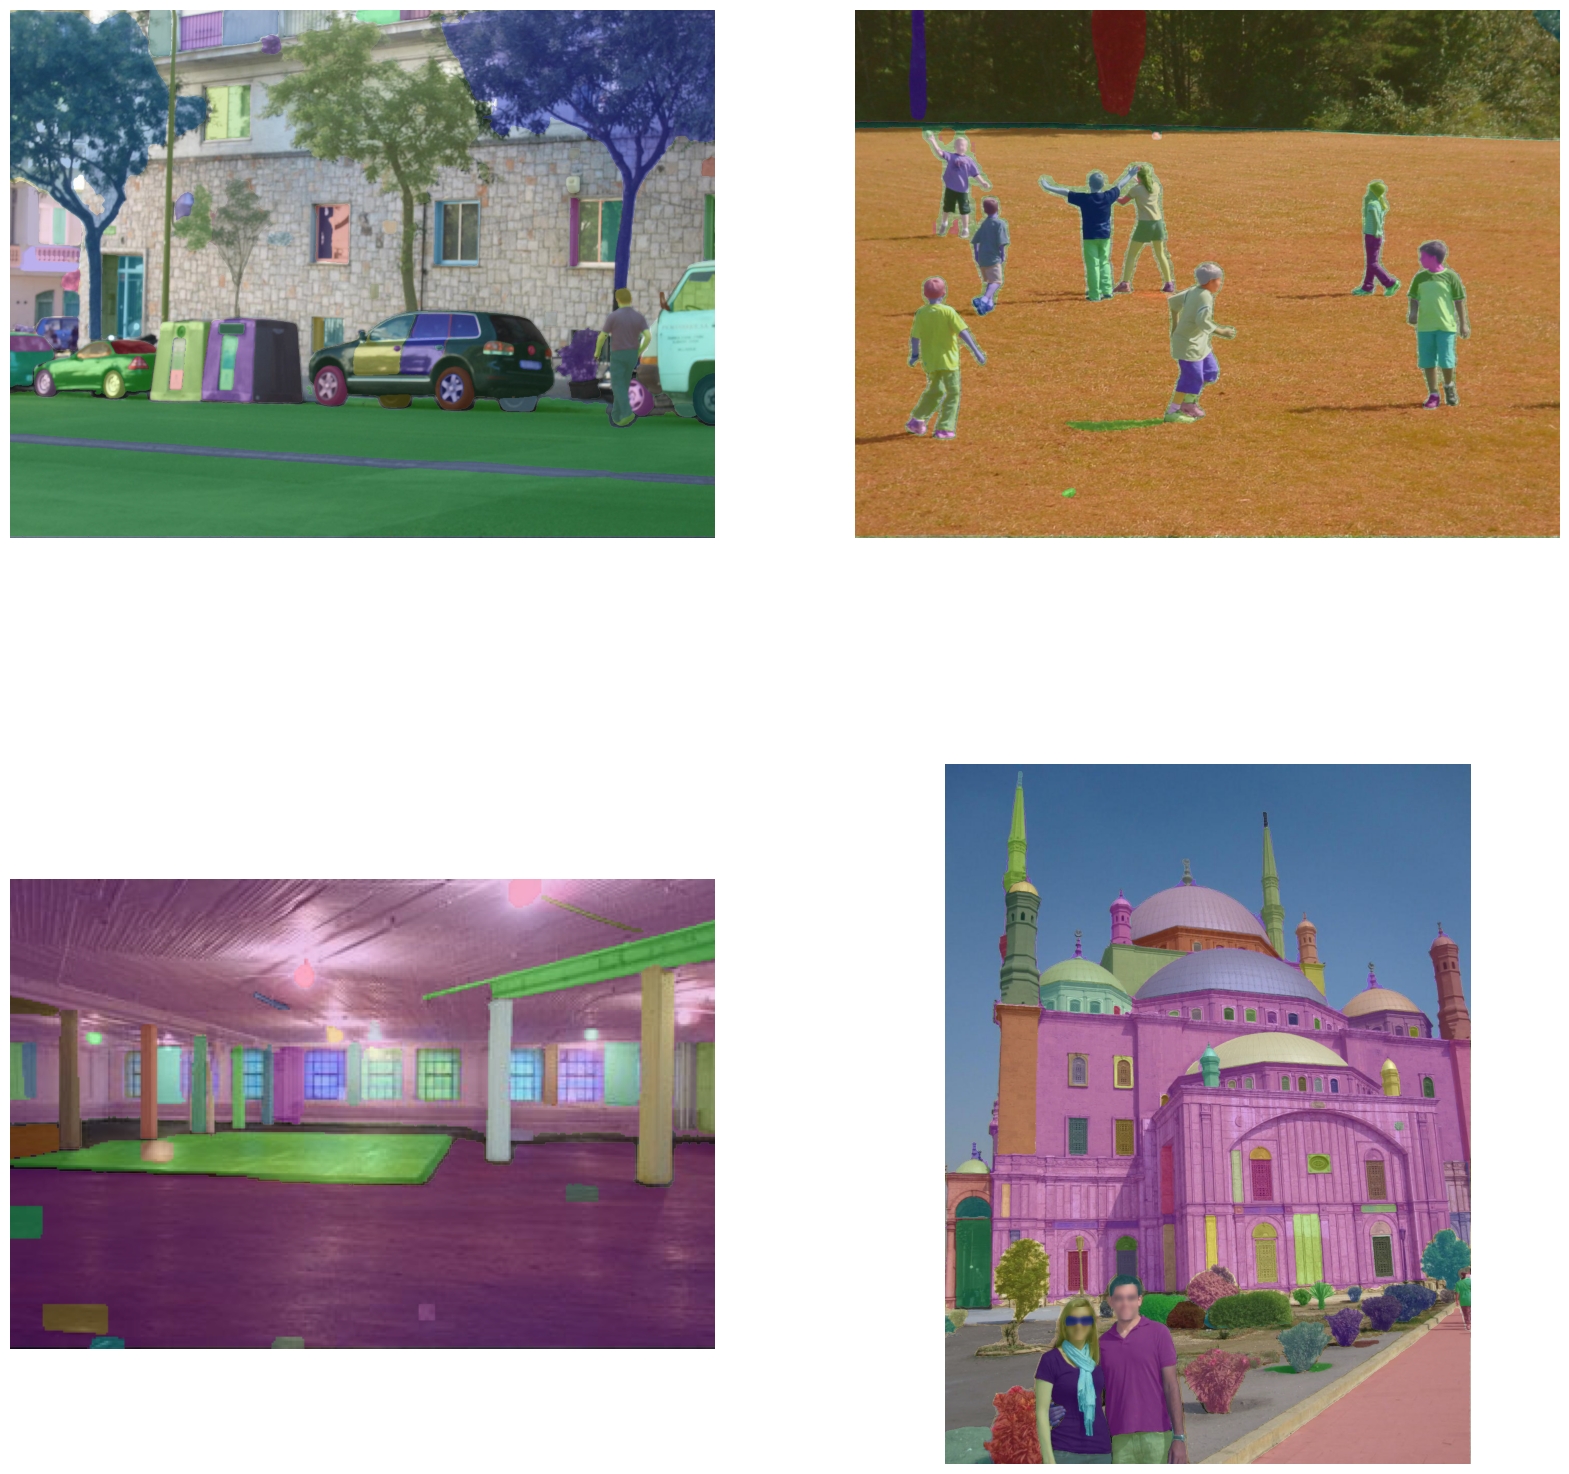

In [ ]:
plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    show_anns(masks[i])
    plt.axis('off')


In [5]:
sam_agnostic = SamAgnosticPredictor(sam)
batch = [{"image": image[None]}]
masks = sam_agnostic.batched_generate(batch)
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks[0])
plt.axis('off')
plt.show() 

TypeError: batched_generate() missing 1 required positional argument: 'info'

In [7]:
batch = next(trainer.vali_dl)
x,model_kwargs,info = trainer.get_kwargs(batch, gen=True)
print(model_kwargs.keys())

dict_keys(['image', 'bbox', 'points', 'cond', 'classes', 'image_features'])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.